# What kind of users are there? Which benefit to associate with each type of users?

## Out line of the problem
- ### A senior VP would like to understand the various kinds of users who use the company’s products.

- ### Especially interested in geting an idea of which benefits to associate with each new card offering.

## Approach

- ### Cluster users based on their credit card usage. 

- ### Characterize each type of users.

- ### Associate benefits to each type of users.

## Summary

- ### Classified users into 5 types.

- ### For users with high "cash advance" transactions, offer them introductory low fees for cash advance. This should attract more customers of this type. They tend to have higher balance (and low percentage of full payment), so the company can increase the revenue through interest fees.

- ### For users with high "installment purchases", offer them interest fee installment plans (with installment fees). These users carry low balance to beging with.

- ### For users with high "one off purchase", encourage their purchases by providing them with higher credit limit. These users do not use "cash advance" features. Otherwise have average activity. Increase in the overall activity should increase company revenue.

- ### There were small number of low balance, low limit, and low payment (0 percent full payment) users. These were also ones with short tenure. Could be inactive users or fraudulent transaction. No need to associate introductory offers for now.

## Relevant analyses

In [71]:
#Import necessary packages

import numpy as np
import pandas as pd
import os
import pickle

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sb
color = sb.color_palette()
%matplotlib inline

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from sklearn import preprocessing as pp 
from sklearn.decomposition import PCA

import itertools

from scipy import linalg
import matplotlib as mpl

from sklearn import mixture


#We probably need packages for clustering. Add later

### Read in the data, check values

In [72]:
#Read the test_results.csv
current_path = os.getcwd()
file = '/datasets/CreditCardUsers/cc_info.xlsx'
cc_users = pd.read_excel(current_path + file)

In [73]:
#Check for null values.
cc_users.isnull().sum()

CUST_ID                               0
BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

### Users with no "minimum payments" has 0% full payment. fradulant transactions?

In [74]:
#Users with no "minimum payments" has 0% full payment. fradulant transactions?
no_minimum = cc_users.loc[(cc_users['MINIMUM_PAYMENTS'].isnull())]
no_minimum.describe()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
count,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000,0.0,313.0,313.000000
mean,555.441321,0.389403,393.087284,250.433387,142.653898,559.136698,0.336043,0.107886,0.244670,0.067169,1.460064,5.833866,3731.789137,322.286168,NaN,0.0,11.063898
std,1292.687887,0.408341,757.905701,624.453991,311.289043,1185.132567,0.372517,0.227370,0.359756,0.130087,3.182359,9.600908,2924.606153,1996.658905,NaN,0.0,1.869734
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,500.000000,0.000000,NaN,0.0,6.000000
25%,0.187069,0.090909,1.400000,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,1.000000,1500.000000,0.000000,NaN,0.0,12.000000
50%,16.848358,0.181818,130.400000,0.000000,0.000000,0.000000,0.166667,0.000000,0.000000,0.000000,0.000000,2.000000,3000.000000,0.000000,NaN,0.0,12.000000
75%,286.686616,1.000000,399.950000,176.030000,152.280000,480.104401,0.583333,0.083333,0.416667,0.083333,1.000000,8.000000,5000.000000,0.000000,NaN,0.0,12.000000
max,9164.724752,1.000000,7597.090000,6761.290000,2959.240000,7616.064965,1.000000,1.000000,1.000000,1.000000,21.000000,77.000000,19500.000000,29272.486070,NaN,0.0,12.000000


### Replace the null values with zero for now

In [75]:
cc_users.loc[(cc_users.loc[:,'MINIMUM_PAYMENTS'].isnull())] = 0

In [76]:
no_limit = cc_users.loc[(cc_users['CREDIT_LIMIT'].isnull())]
no_limit.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
5203,C15349,18.400472,0.166667,0.0,0.0,0.0,186.853063,0.0,0.0,0.0,0.166667,1,0,NaN,9.040017,14.418723,0.0,6


In [77]:
#drop the row with no credi limit.
cc_users = cc_users.dropna()

In [78]:
Features = cc_users.iloc[:,1:18]

### Try to reduce the number of features with PCA. Center and standardize the features first.

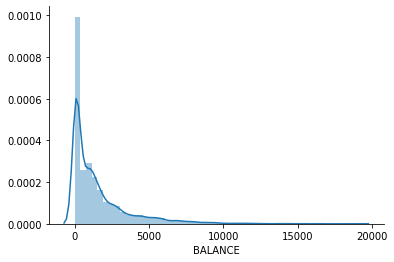

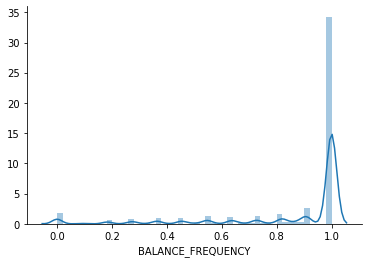

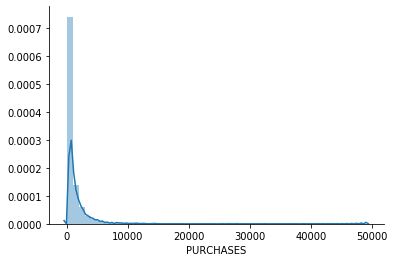

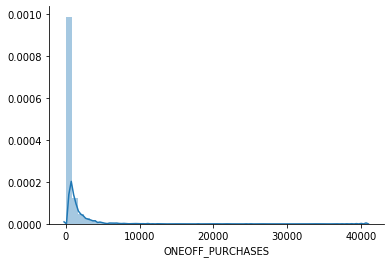

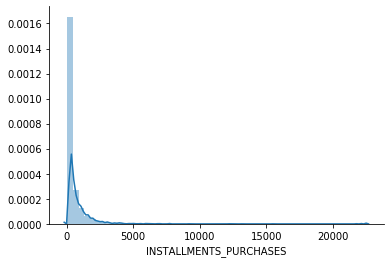

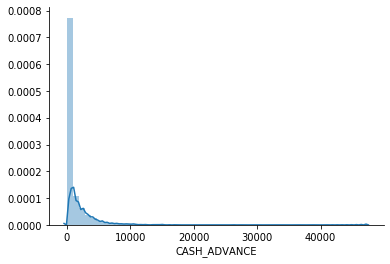

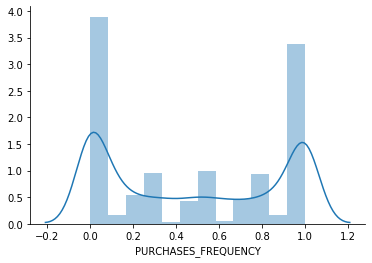

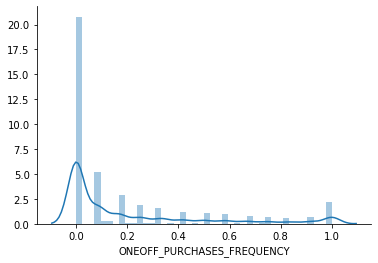

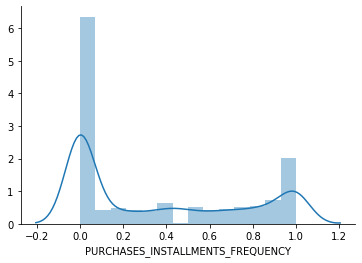

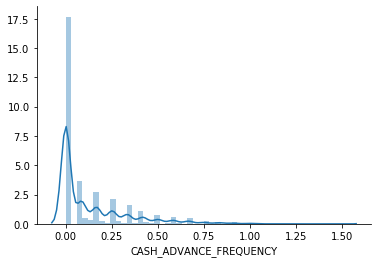

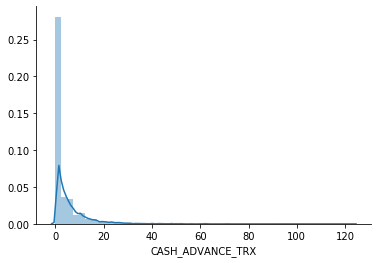

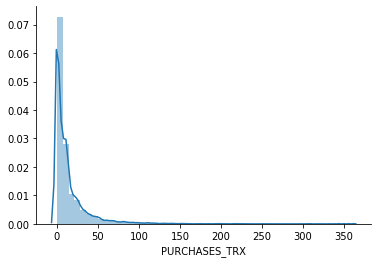

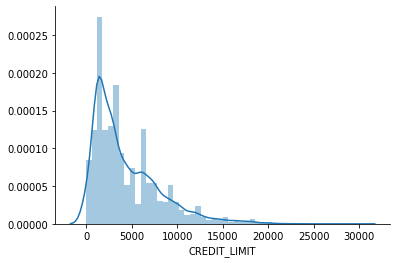

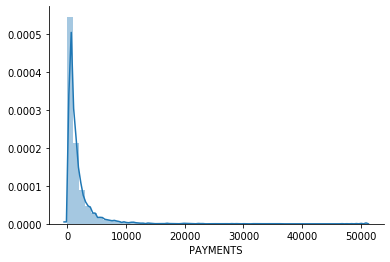

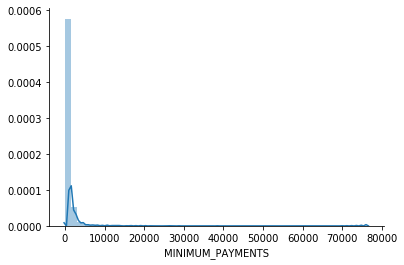

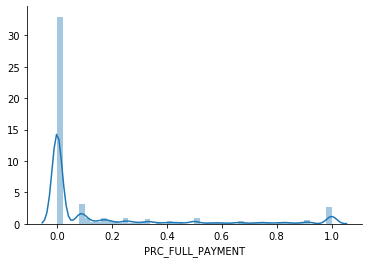

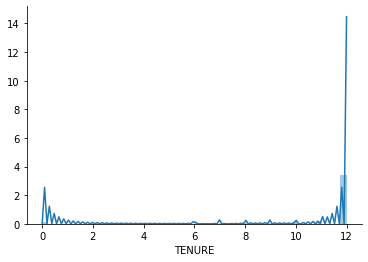

In [80]:
#Check the distribution of the features.

for column in Features:
    plt.figure()
    sb.distplot(Features.loc[:,column])
    sb.despine()

### for positively skewed data, apply log transform

In [81]:
#Make a new dataframe for the transformed values
Features_transformed = pd.DataFrame().reindex_like(Features)


#Add 0.1 to avoid negative infinity for log zero.
Features_transformed['BALANCE']=np.log(Features['BALANCE']+0.1)
Features_transformed['PURCHASES']=np.log(Features['PURCHASES']+10)
Features_transformed['ONEOFF_PURCHASES']=np.log(Features['ONEOFF_PURCHASES']+10)
Features_transformed['INSTALLMENTS_PURCHASES']=np.log(Features['INSTALLMENTS_PURCHASES']+10)
Features_transformed['CASH_ADVANCE']=np.log(Features['CASH_ADVANCE']+10)
#purchase frequency has two peaks 0 and 1. keep as is.
Features_transformed['PURCHASES_FREQUENCY']=Features['PURCHASES_FREQUENCY']
Features_transformed['ONEOFF_PURCHASES_FREQUENCY']=np.log(Features['ONEOFF_PURCHASES_FREQUENCY']+0.1)
#purchases_installment_frequency also has two peaks 0 and 1. keep as is.
Features_transformed['PURCHASES_INSTALLMENTS_FREQUENCY']=Features['PURCHASES_INSTALLMENTS_FREQUENCY']
Features_transformed['CASH_ADVANCE_FREQUENCY']=np.log(Features['CASH_ADVANCE_FREQUENCY']+0.1)
Features_transformed['CASH_ADVANCE_TRX']=np.log(Features['CASH_ADVANCE_TRX']+0.1)
Features_transformed['PURCHASES_TRX']=np.log(Features['PURCHASES_TRX']+0.1)
Features_transformed['CREDIT_LIMIT']=np.log(Features['CREDIT_LIMIT']+10)
Features_transformed['PAYMENTS']=np.log(Features['PAYMENTS']+10)
Features_transformed['MINIMUM_PAYMENTS']=np.log(Features['MINIMUM_PAYMENTS']+10)
Features_transformed['PRC_FULL_PAYMENT']=np.log(Features['PRC_FULL_PAYMENT']+0.1)
#Keep tenure as is.
Features_transformed['TENURE']=Features['TENURE']


### for negatively skewed data, flip, apply log transform, then flip back

In [82]:
#Flip first
Flip=1.1-Features['BALANCE_FREQUENCY']
#Then take log
log_flip=np.log(Flip)
#The flip back.
Features_transformed['BALANCE_FREQUENCY']=max(log_flip)-log_flip


In [15]:
#Standarize
scalerFeatures_transformed = pp.StandardScaler().fit(Features_transformed)
Features_standardized = scalerFeatures_transformed.transform(Features_transformed)
Features_standardizedDF=pd.DataFrame(data=Features_standardized)


### Distributions are close to normal after transformation and standardization 

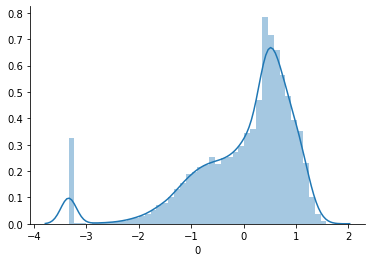

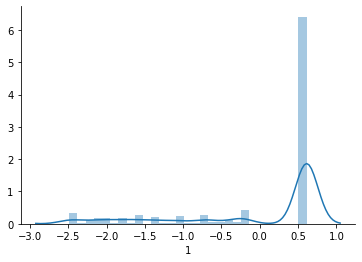

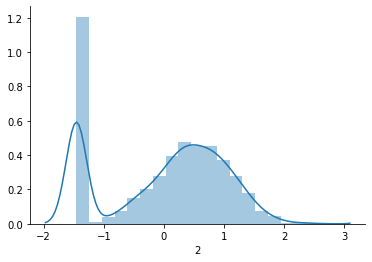

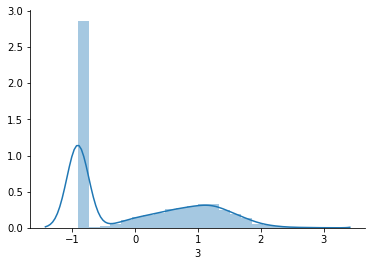

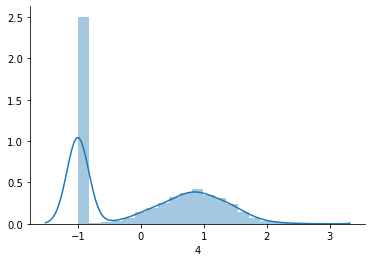

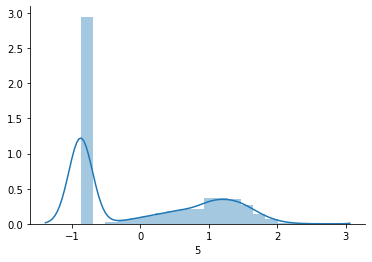

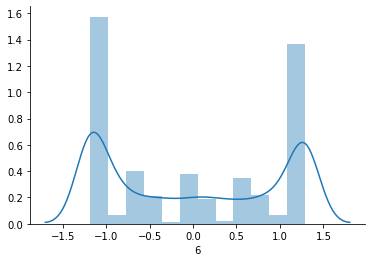

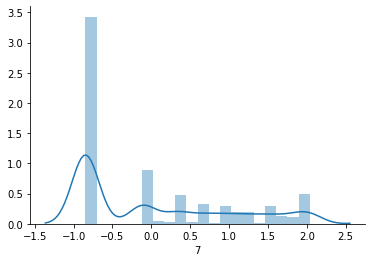

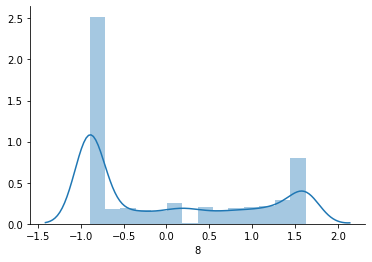

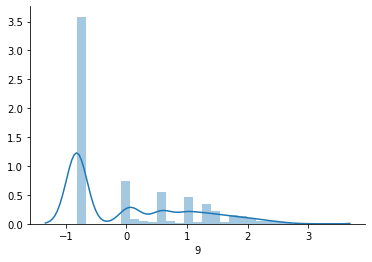

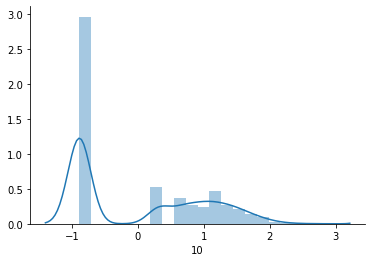

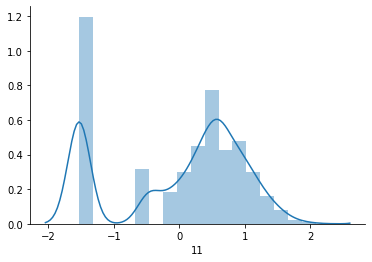

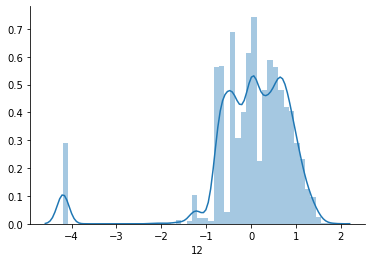

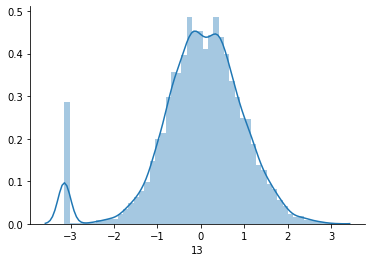

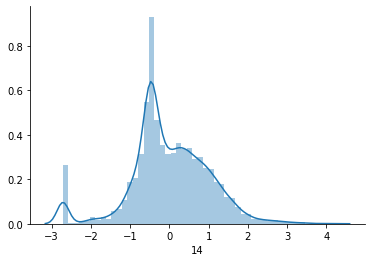

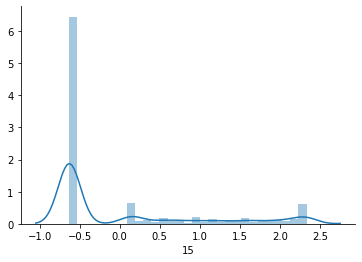

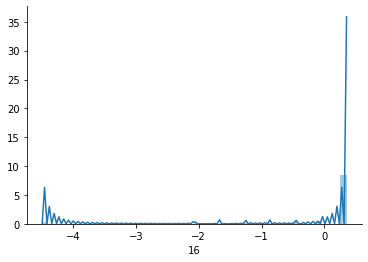

In [83]:
for column in Features_standardizedDF:
    plt.figure()
    sb.distplot(Features_standardizedDF.loc[:,column])
    sb.despine()

### Run Principal Component Analysis and see how much variance is explained by each components

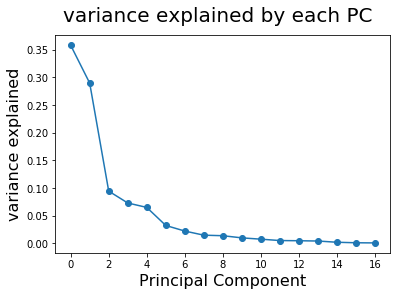

In [17]:
#Run PCA to reduce the features
pcaA=PCA(n_components=17)
pcaA.fit(Features_standardizedDF)

#check the variance explained.
#print(pca.explained_variance_ratio_)
plt.plot(pcaA.explained_variance_ratio_,'o-')
plt.suptitle('variance explained by each PC', fontsize = 20)
plt.ylabel('variance explained', fontsize = 16)
plt.xlabel('Principal Component', fontsize=16)
plt.show()

#trasform the Answers into principal component space
DataArrayPCA_features=pcaA.transform(Features_standardized)

### Try clustering with top 5 components.

### Plot data in 3D using top 3 principal components

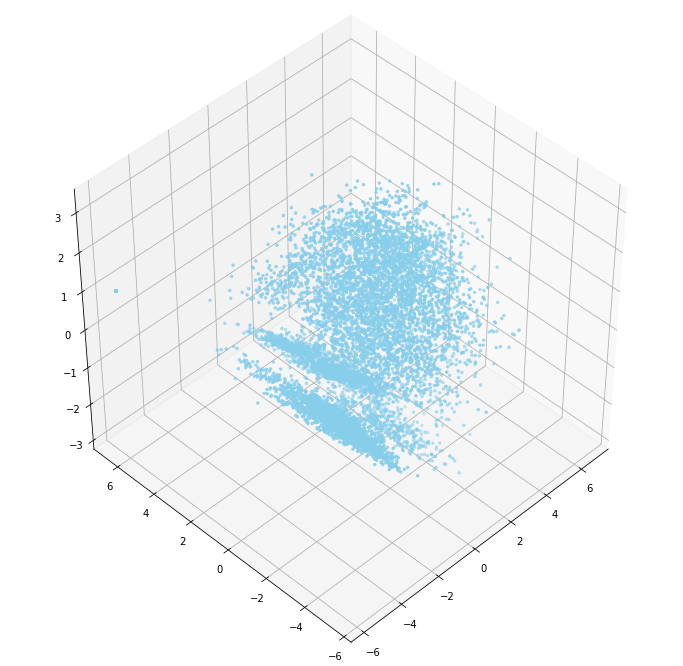

In [20]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(DataArrayPCA_features[:,0],DataArrayPCA_features[:,1],DataArrayPCA_features[:,2], c='skyblue', s=6)
ax.view_init(45, 225)
plt.show()


### Try gaussian mixed model because we have clusters with different size.

In [84]:
bic = []
n_components_range = range(1, 20)

for n_components in n_components_range:
    
    # Fit a Gaussian mixture with EM
    gmm = mixture.GaussianMixture(n_components=n_components,
                                      covariance_type='full')
    gmm.fit(DataArrayPCA_features[:,0:5])
    bic.append(gmm.bic(DataArrayPCA_features[:,0:5]))

bic = np.array(bic)


Text(0.5, 0, 'cluster number')

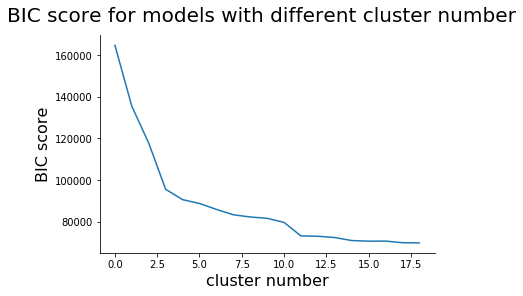

In [87]:
sb.lineplot(data=bic)
sb.despine()
plt.suptitle('BIC score for models with different cluster number', fontsize = 20)
plt.ylabel('BIC score', fontsize = 16)
plt.xlabel('cluster number', fontsize=16)

### Use 5 clusters (where the BIC's decline slows down): Run Gaussian mixture with EM using 5 clusters.

In [89]:
# Fit a Gaussian mixture with EM
gmm = mixture.GaussianMixture(n_components=5,
                                      covariance_type='full')
gmm.fit(DataArrayPCA_features[:,0:5])

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=5, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

In [40]:
#Predict the label for each data point.
Y_ = gmm.predict(DataArrayPCA_features[:,0:5])

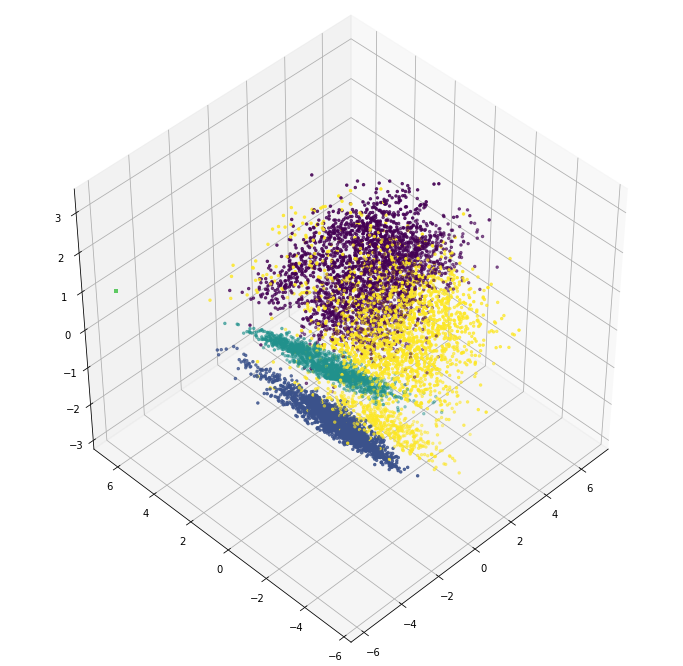

In [41]:
#Show 3D plot of where each cluster is

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(DataArrayPCA_features[:,0],DataArrayPCA_features[:,1],DataArrayPCA_features[:,2], c=Y_, s=6)
ax.view_init(45, 225)
plt.show()


In [44]:
#Count all the group number (because we know one is an outlier)
Y_df=pd.DataFrame(data=Y_,columns=['cluster'])
Y_df['cluster'].value_counts()

0    2613
4    2407
1    1945
2    1671
3     313
Name: cluster, dtype: int64

### Calculate the mean of each cluster in the original feature space

In [49]:
#May be a better idea to just get the mean for all the clusters for all the features
#Then we can plot 7 lines and decide what are the features that distinguish them apart.
#Then we will come up with the recomendations.
n_of_clusters = 5
n_of_features = 17

mean_features = np.zeros((n_of_clusters,n_of_features))

#Features for all data points after standardization = Features_standardizedDF

#Y_df['cluster'] contains cluster info

for clusters in range(n_of_clusters):
    group_data = Features_standardizedDF.loc[Y_df['cluster']==clusters,:]
    mean_features[clusters,:]=group_data.mean(axis=0)

In [64]:
plot_data = np.zeros((n_of_features,n_of_clusters))

for rows in range(n_of_clusters):
    plot_data[:,rows]=mean_features[rows,:]
    
plot_data_df = pd.DataFrame(plot_data,columns=['cluster 0','cluster 1','cluster 2','cluster 3','cluster 4'],index=Features.columns) 

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16],
 <a list of 17 Text xticklabel objects>)

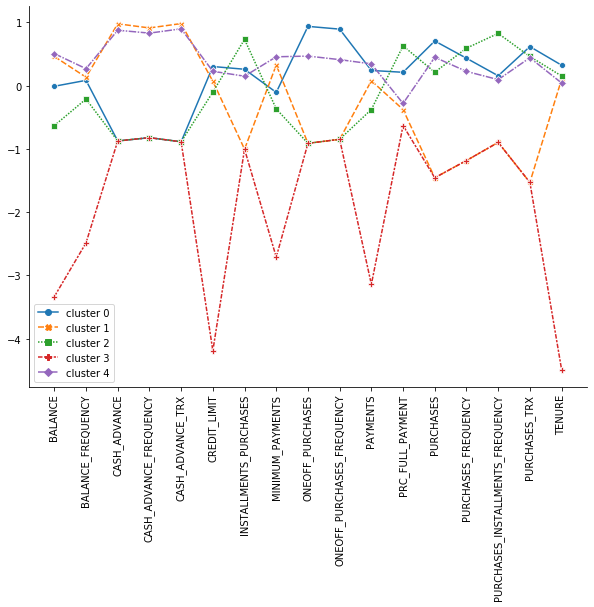

In [70]:
fig = plt.figure(figsize=(10,7))
sb.lineplot(data = plot_data_df, markers = True)
sb.despine()
plt.xticks(rotation = 90)


### Cluster 0: More "one off purchases" than "cash advance", otherwise average use
### Cluster 1: More "cash advance", "less purchases", "high balance", and "low prc full payment"
### Cluster 2: Less "cash advance", more "installment purchases", but "low balance" and "high prc full payments"
### Cluster 3: low balance, low limit, low payment, low tenure. Non-active users or fraudulent transactions?
### Cluster 4: High "cash advance", average "purchases", "high balance", low "full payment"

## Results



- ### For users with high "cash advance" transactions, offer them introductory low fees for cash advance. This should attract more customers of this type. They tend to have higher balance (and low percentage of full payment), so the company can increase the revenue through interest fees.

- ### For users with high "installment purchases", offer them interest fee installment plans (with installment fees). These users carry low balance to beging with.

- ### For users with high "one off purchase", encourage their purchases by providing them with higher credit limit. These users do not use "cash advance" features. Otherwise have average activity. Increase in the overall activity should increase company revenue.

- ### There were small number of low balance, low limit, and low payment (0 percent full payment) users. These were also ones with short tenure. Could be inactive users or fraudulent transaction. No need to associate introductory offers for now.